# Clean Architectures

## Use Case: Image Processing

In [1]:
from override_decorator import override
import time
from pathlib import Path

## Entities

In [2]:
from abc import ABC, abstractmethod
from typing import Any

class Entity(ABC):

    @abstractmethod
    def getDescription(self) -> str:
        raise NotImplementedError

## Interfaces / Actors

In [3]:
class Interface(ABC):

    @abstractmethod
    def execute(self, **kwargs) -> Entity:
        raise NotImplementedError

## Use Cases

In [4]:
class UseCase(ABC):

    @abstractmethod
    def execute(self, **kwargs) -> Entity:
        raise NotImplementedError

## Handlers

In [5]:
class Handler(ABC):
    
    @abstractmethod
    def execute(self) -> Entity:
        raise NotImplementedError

# Implementation

## Entities

In [6]:
class Image(Entity):

    def __init__(self, image: Any) -> None:
        self._timestamp = self.setTimeStamp()
        self._image = image

    def setTimeStamp(self) -> None:
        timestamp = time.time()
        time_struct = time.localtime(timestamp) 
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time_struct)
        self._timestamp = timestamp

    def setImage(self, image: Any) -> None:
        self._image = image

    def getTimeStamp(self) -> str:
        return self._timestamp
    
    def getImage(self):
        return self._image
    
    @override(Entity)
    def getDescription(self) -> str:
        return f"{self.__class__.__name__} (Entity)"

## Interface

In [7]:
class ImageReader(Interface):
        
    @abstractmethod
    def toImage(self, image: Any) -> Image:
        raise NotImplementedError
    
    @abstractmethod
    def readImage(self, image_path: Path) -> Any:
        raise NotImplementedError

In [8]:
from typing import Any
import cv2

class OpenCVImageReader(ImageReader):

    def __init__(self) -> None:
        print(f"{self.__class__.__name__}")

    @override(ImageReader)
    def toImage(self, image: Any) -> Image:
        return Image(image)

    @override(ImageReader)
    def readImage(self, image_filepath: Path) -> Any:
        return cv2.imread(str(image_filepath))
    
    @override(Interface)
    def execute(self, image_filepath: Path) -> Entity:
        
        image = self.readImage(image_filepath)
        image = self.toImage(image)

        return image

## Use Case

In [9]:
class ReadImageUseCase(UseCase):

    def __init__(self, image_reader: ImageReader):
        self._image_reader = image_reader

    @override(UseCase)
    def execute(self, image_filepath: Path) -> Entity:
        return self._image_reader.execute(image_filepath=image_filepath)

## Handler

In [10]:
from dependency_injector.wiring import inject, Provide
import matplotlib.pyplot as plt

# handler will handle few or more use cases
class ImageQualityControlHandler(Handler):

    @inject
    def __init__(self, read_image_use_case: ReadImageUseCase) -> None:
        super().__init__()
        self.read_image_use_case = read_image_use_case

    def read_image(self, image_filepath: Path) -> Entity:
        image: Image = self.read_image_use_case.execute(image_filepath)
        return image

    def execute(self, **kwargs) -> Entity:
        # 1. read image
        image = self.read_image(kwargs['image_filepath'])
        plt.imshow(image.getImage())

In [11]:
from dependency_injector import containers, providers
import os

class SystemDeclarator(containers.DeclarativeContainer):

    # Interfaces
    image_reader = providers.Singleton(OpenCVImageReader)

    # Use Cases
    read_image_use_case = providers.Factory(ReadImageUseCase, image_reader=image_reader)

    # Handler
    image_quality_control_handler = providers.Factory(ImageQualityControlHandler, 
                                                      read_image_use_case=read_image_use_case)

OpenCVImageReader


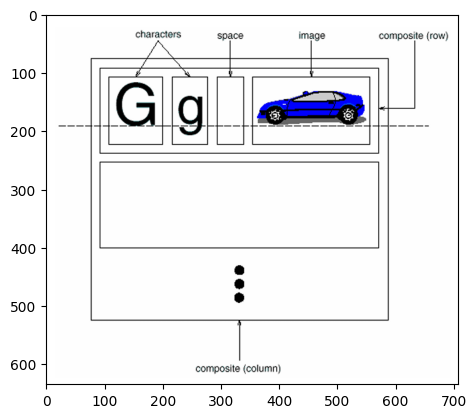

In [12]:
image_filepath = Path(os.environ.get('IMAGE_FILEPATH', 'Study Case/assets/1. Recursive Composition of Text and Graphics.png'))

# Create the container instance
container = SystemDeclarator()
container.init_resources()
container.wire(modules=[__name__])

# Create an instance of ImageQualityControlHandler with dependencies automatically injected
image_quality_control_handler = container.image_quality_control_handler()

# Now you can use the handler
image_quality_control_handler.execute(image_filepath=image_filepath)
